In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 分布的形式化

## 物理意义

[Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution) 分布是一种极值型分布。举例而言，假设每次测量心率值为一个随机变量（服从某种[指数族分布](https://en.wikipedia.org/wiki/Exponential_family)，如正态分布），每天测量10次心率并取最大的一个心率值作为当天的心率测量值。显然，每天纪录的心率值也是一个随机变量，并且它的概率分布即为 Gumbel 分布。


## 概率密度函数（PDF）

Gumbel 分布的 PDF 如下：

$$f(x;\mu,\beta) = e^{-z-e^{-z}},\ z= \frac{x - \mu}{\beta}$$

公式中，$\mu$ 是位置系数（Gumbel 分布的众数是 $\mu$），$\beta$ 是尺度系数（Gumbel 分布的方差是 $\frac{\pi^2}{6}\beta^2$）。

![PDF](https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Gumbel-Density.svg/488px-Gumbel-Density.svg.png)
**Gumble PDF 示例图【[src](https://en.wikipedia.org/wiki/Gumbel_distribution)】**



In [2]:
def gumbel_pdf(x, mu=0, beta=1):
    z = (x - mu) / beta
    return np.exp(-z - np.exp(-z)) / beta

print(gumbel_pdf(0.5, 0.5, 2))

0.183939720586


## 累计密度函数（CDF）
相应的，gumbel 分布的 CDF 的公式如下：

$$F(z;\mu,\beta) = e^{-e^{-(x-\mu)/\beta}}$$



In [3]:
def gumbel_cdf(x, mu=0, beta=1):
    z = (x - mu) / beta
    return np.exp(-np.exp(-z))
    
print(gumbel_cdf(5, 0.5, 2))    

0.899965162661


## CDF 的反函数
根据 CDF 容易得到其反函数：

$$F^{-1}(y;\mu,\beta) = \mu - \beta \ln(-\ln(y))$$

我们可以利用反函数法和生成服从 Gumbel 分布的随机数。


In [4]:
def inv_gumbel_cdf(y, mu=0, beta=1, eps=1e-20):
    return mu - beta * np.log(-np.log(y + eps))

print(inv_gumbel_cdf(gumbel_cdf(5, 0.5, 2), 0.5, 2))

def sample_gumbel(shape):
    p = np.random.random(shape)
    return inv_gumbel_cdf(p)

print(sample_gumbel([2,3]))

5.0
[[ 2.26084029  1.69630763 -0.71364075]
 [ 1.1703834   1.65582117  2.7283681 ]]


# 2. Gumbel-Max

Gumbel 随机数可以用来对多项分布进行采样。

## 2.1 基于 softmax 的采样

首先来看常规的采样方法。

对于 $logits = (x_1, \dots, x_K)$，首先利用 softmax 运算得到规一化的概率分布（多项分布）。

$$\pi_k = \frac{exp\{x_k\}}{\sum_{k\prime=1}^{K} exp\{x_{k\prime}\}}$$

然后，利用轮盘赌的方式采样。下面的代码，直接使用 numpy 的 [choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) 函数实现。



In [5]:
def softmax(logits):
    max_value = np.max(logits)
    exp = np.exp(logits - max_value)
    exp_sum = np.sum(exp)
    dist = exp / exp_sum
    return dist

def roulette(p):
    p = np.asarray(p)
    cdf = p.cumsum()
    r = np.random.random()
    for i in range(len(cdf)):
        if r <= cdf[i]: break
    return i

def sample_with_softmax(logits, size):
    '''
    pros = softmax(logits)

    ret = np.empty(np.product(size)).astype('int')
    for i in range(len(ret)):
        ret[i] = roulette(pros)
        
    return ret.reshape(size)
    '''
    
    pros = softmax(logits)
    return np.random.choice(len(logits), size, p=pros)

## 2.2 基于 gumbel 的采样（gumbel-max）
对于某组 logits，生成相同数量的 gumbel 随机数，并加到 logits 上。 然后选择数值最大的元素的编号作为采样值。
示例代码如下：

In [6]:
def sample_with_gumbel_noise(logits, size):
    noise = sample_gumbel((size, len(logits)))
    return np.argmax(logits + noise, axis=1)

可以[证明](https://hips.seas.harvard.edu/blog/2013/04/06/the-gumbel-max-trick-for-discrete-distributions/)，gumbel-max 方法的采样效果等效于基于 softmax 的方式。下面的实验直观地展示两种方法的采样效果。


(array([  4358.,  22962.,   7143.,   6761.,   3638.,   5848.,   5946.,
         15969.,   9951.,  17424.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

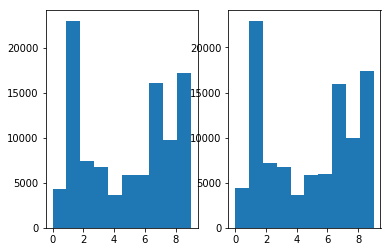

In [7]:
np.random.seed(1111)
logits = (np.random.random(10) - 0.5) * 2  # (-1, 1)
    
pop = 100000
softmax_samples = sample_with_softmax(logits, pop)
gumbel_samples = sample_with_gumbel_noise(logits, pop)
        
plt.subplot(1, 2, 1)
plt.hist(softmax_samples)
    
plt.subplot(1, 2, 2)
plt.hist(gumbel_samples)

由于 Gumbel 随机数可以预先计算好，采样过程也不需要计算 softmax，因此，某些情况下，gumbel-max 方法相比于 softmax，在采样速度上会有优势。

# 3. Gumbel-Softmax

如果仅仅是提供一种常规 softmax 采样的替代方案， gumbel 分布似乎应用价值并不大。幸运的是，我们可以利用 gumbel 实现多项分布采样的 reparameterization（再参数化）。

在介绍 [VAE](http://blog.csdn.net/jackytintin/article/details/53641885) 的时候讨论过，为了实现端到端的训练，VAE 采用的一个再参数化的技巧对高斯分布进行采样:

In [8]:
def guassian_sample(shape):
    epsilon = K.random_normal(shape, mean=0.,std=1) # 标准高斯分布
    z = z_mean + exp(z_log_var / 2) * epsilon

在介绍的 VAE 里，假设隐变量（latent variables）服从标准正态分布。下面将会看到，利用 gumbel-softmax 技巧，我们可以将隐变量建模为服从离散的多项分布。

在上面的示例中，sample_with_softmax 使用了 choise 操作，而这个操作是不可导的。同样，观察 sample_with_gumbel_noise, armmax 操作同样不可导。然而，argmax 有一个 soft 版本，即 **softmax**。

我们首先扩展上面定义的 softmax 函数，添加一个 temperature 参数。

In [9]:
def generalized_softmax(logits, temperature=1):
    logits /= temperature
    return softmax(logits)

temperature 是在大于零的参数，它控制着 softmax 的 soft 程度。温度越高，生成的分布越平滑；温度越低，生成的分布越接近离散的 one-hot 分布。下面示例对比了不同温度下，softmax 的结果。

<Container object of 10 artists>

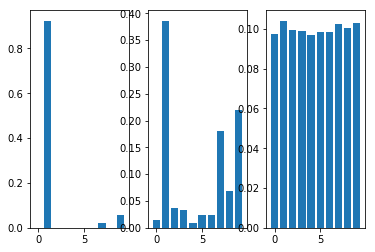

In [10]:
np.random.seed(1111)
n = 10
logits = (np.random.random(n) - 0.5) * 2  # (-1, 1)
x = range(n)

plt.subplot(1, 3, 1)
t = .1
plt.bar(x, generalized_softmax(logits, t))

plt.subplot(1, 3, 2)
t = 5
plt.bar(x, generalized_softmax(logits, t))

plt.subplot(1, 3, 3)
t = 50
plt.bar(x, generalized_softmax(logits, t))


将 gumbel-max 中的 argmax 操作，替换为 softmax，便实现了对于原来不可导的采样操作的软化版的近似。训练中，可以通过逐渐降低温度，以逐步逼近真实的离散分布。利用 gumbel-softmax，VAE 的隐变量可以用多项分布进行建模，一个示例见 [repo](https://github.com/DingKe/ml-tutorial/tree/master/gumbel)。这里，仅展示一个 toy 示例（代码[来自](http://amid.fish/humble-gumbel)）。

In [11]:
import tensorflow as tf
sess = tf.Session()

def differentiable_sample(logits, temperature=1):
    noise = tf.random_uniform(tf.shape(logits), seed=11)
    logits_with_noise = logits - tf.log(-tf.log(noise))
    return tf.nn.softmax(logits_with_noise / temperature)

mean = tf.Variable(2.)
idxs = tf.Variable([0., 1., 2., 3., 4.])
# An unnormalised approximately-normal distribution
logits = tf.exp(-(idxs - mean) ** 2)
sess.run(tf.global_variables_initializer())

def print_logit_vals():
    logit_vals = sess.run(logits)
    print(" ".join(["{:.2f}"] * len(logit_vals)).format(*logit_vals))
    
print("Logits: ")
print_logit_vals()

sample = differentiable_sample(logits)
sample_weights = tf.Variable([1., 2., 3., 4., 5.], trainable=False)
result = tf.reduce_sum(sample * sample_weights)

sess.run(tf.global_variables_initializer())
train_op = tf.train.GradientDescentOptimizer(learning_rate=1).minimize(-result)

print("Distribution mean: {:.2f}".format(sess.run(mean)))
for i in range(5):
    sess.run(train_op)
    print("Distribution mean: {:.2f}".format(sess.run(mean)))

Logits: 
0.02 0.37 1.00 0.37 0.02
Distribution mean: 2.00
Distribution mean: 2.13
Distribution mean: 2.23
Distribution mean: 2.60
Distribution mean: 2.75
Distribution mean: 3.23


可以看到，利用 gumbel-softmax 训练参数向着预期的方向改变。

In [12]:
import tensorflow as tf
sess = tf.Session()

mean = tf.Variable(2.)
idxs = tf.Variable([0., 1., 2., 3., 4.])
# An unnormalised approximately-normal distribution
logits = tf.exp(-(idxs - mean) ** 2)
sess.run(tf.global_variables_initializer())

def print_logit_vals():
    logit_vals = sess.run(logits)
    print(" ".join(["{:.2f}"] * len(logit_vals)).format(*logit_vals))
    
print("Logits: ")
print_logit_vals()

sample = tf.nn.softmax(logits)
sample_weights = tf.Variable([1., 2., 3., 4., 5.], trainable=False)
result = tf.reduce_sum(sample * sample_weights)

sess.run(tf.global_variables_initializer())
train_op = tf.train.GradientDescentOptimizer(learning_rate=1).minimize(-result)

print("Distribution mean: {:.2f}".format(sess.run(mean)))
for i in range(5):
    sess.run(train_op)
    print("Distribution mean: {:.2f}".format(sess.run(mean)))

Logits: 
0.02 0.37 1.00 0.37 0.02
Distribution mean: 2.00
Distribution mean: 2.32
Distribution mean: 2.65
Distribution mean: 2.87
Distribution mean: 3.10
Distribution mean: 3.36


# 讨论
乍看起来，gumbel-softmax 的用处令人费解。比如上面的代码示例，直接使用 softmax，也可以达到类似的参数训练效果。但两者有着根本的区别。
原理上，常规的 softmax 直接建模了一个概率分布（多项分布），基于交叉熵的训练准则使分布尽可能靠近目标分布；而 gumbel-softmax 则是对多项分布采样的一个近似。使用上，常规的有监督学习任务（分类器训练）中，直接学习输出的概率分布是自然的选择；而对于涉及采样的学习任务（VAE 隐变量采样、强化学习中对actions 集合进行采样以确定下一步的操作），gumbel-softmax 提供了一种再参数化的方法，使得模型可以以端到端的方式进行训练。

# References
1. http://amid.fish/humble-gumbel
2. [proof of Gumbel based sampling](https://hips.seas.harvard.edu/blog/2013/04/06/the-gumbel-max-trick-for-discrete-distributions/)
3. https://blog.evjang.com/2016/11/tutorial-categorical-variational.html
4. Jang et al. [CATEGORICAL REPARAMETERIZATION WITH GUMBEL-SOFTMAX](https://arxiv.org/abs/1611.01144).
